## Module 2 - Stacks: linear regression model

In [1]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import pyro
from scipy import stats
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule
from pyro.infer import MCMC, NUTS

import random
import numpy as np
import time
import random
import pandas as pd
from collections import defaultdict
import plotly.express as px
import re
import itertools

pyro.set_rng_seed(1)

# pd.options.plotting.backend = "plotly"
%matplotlib inline
plt.style.use('default')

**Stack Model definition**

**beta0 ~ normal(0, 316);**

**beta ~ normal(0, 316);**

**sigmasq ~ inv_gamma(.001, .001);**

In [5]:
def StackModel(X1, X2, X3, Y):
    beta0 = pyro.sample("beta0", dist.Normal(0., 316.))
    beta1 = pyro.sample("beta1", dist.Normal(0., 316))
    beta2 = pyro.sample("beta2", dist.Normal(0., 316))
    beta3 = pyro.sample("beta3", dist.Normal(0., 316))
    sigma = pyro.sample("sigma", dist.InverseGamma(0.001, 0.001))
    sigma = torch.sqrt(sigma)
    mu = beta0 + beta1 * X1 + beta2 * X2 + beta3*X3
    with pyro.plate("data", len(X1)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=Y)

**Following standardises Data**

In [6]:
transform_data= lambda x:torch.tensor(stats.zscore(x), dtype=torch.float)# standardises Input data

x_data= torch.tensor(np.array([80, 80, 75, 62, 62, 62, 62, 62, 59, 58, 58, 58, 58, 
58, 50, 50, 50, 50, 50, 56, 70, 27, 27, 25, 24, 22, 23, 24, 24, 
23, 18, 18, 17, 18, 19, 18, 18, 19, 19, 20, 20, 20, 89, 88, 90, 
87, 87, 87, 93, 93, 87, 80, 89, 88, 82, 93, 89, 86, 72, 79, 80, 
82, 91]).reshape((21,3)), dtype=torch.float)

y_data= torch.tensor([43, 37, 37, 28, 18, 18, 19, 20, 15, 14, 14, 13, 11, 12, 8, 7, 8, 8, 9, 15, 15], dtype=torch.float)

# X = X.reshape((3,21)).T
X1 = transform_data(x_data[:,0])
X2 = transform_data(x_data[:,1])
X3 = transform_data(x_data[:,2])
Y= y_data
print(X1.shape, X2.shape, X3.shape, Y.shape)

torch.Size([21]) torch.Size([21]) torch.Size([21]) torch.Size([21])


In [7]:
def get_hmc_n_chains(num_chains=4, base_count = 900):
    hmc_sample_chains =defaultdict(dict)
    possible_samples_list= random.sample(list(np.arange(base_count, base_count+num_chains*100, 50)), num_chains)
    possible_burnin_list= random.sample(list(np.arange(100, 500, 50)), num_chains)

    t1= time.time()
    for idx, val in enumerate(list(zip(possible_samples_list, possible_burnin_list))):
        num_samples, burnin= val[0], val[1]
        nuts_kernel = NUTS(StackModel)
        mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=burnin)
        mcmc.run(X1,X2,X3,Y)
        hmc_sample_chains['chain_{}'.format(idx)]={k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

    print("\nTotal time: ", time.time()-t1)
    hmc_sample_chains= dict(hmc_sample_chains)
    return hmc_sample_chains

In [6]:
hmc_sample_chains= get_hmc_n_chains(num_chains=4, base_count = 900)

Sample: 100%|██████████| 1600/1600 [03:31,  7.57it/s, step size=8.37e-02, acc. prob=0.928]


Total time:  753.5873439311981


**Parameter vs. Chain matrix**

In [7]:
beta_chain_matrix_df = pd.DataFrame(hmc_sample_chains)
# beta_chain_matrix_df.to_csv("stack_regression_hmc_sample_chains.csv", index=False)
beta_chain_matrix_df

chain_0  ...                                            chain_3
beta0  [18.71614, 16.050137, 17.946217, 18.919666, 16...  ...  [16.872746, 16.055574, 17.874273, 16.715519, 1...
beta1  [-0.09374528, 14.835045, 12.376676, 13.508068,...  ...  [9.801435, 4.937317, -7.2337184, -2.1739948, -...
beta2  [3.6648269, -13.366175, -13.43537, -11.334033,...  ...  [1.5280538, 10.590756, 14.111094, 10.4125805, ...
beta3  [-6.4204726, -2.1796389, -0.11578185, 1.136406...  ...  [-11.4415245, -15.152795, -6.278599, -5.071878...
sigma  [83.27427, 87.956924, 109.809616, 80.93596, 14...  ...  [122.17643, 113.59428, 120.55852, 106.82512, 1...

[5 rows x 4 columns]

**Key statistic results as dataframe**

In [6]:
all_metric_func_map = lambda metric, vals: {"mean":np.mean(vals), "std":np.std(vals), 
                                            "25%":np.quantile(vals, 0.25), 
                                            "50%":np.quantile(vals, 0.50), 
                                            "75%":np.quantile(vals, 0.75)}.get(metric)

In [10]:
key_metrics= ["mean", "std", "25%", "50%", "75%"]

summary_stats_df_= pd.DataFrame()
for metric in key_metrics:
    final_di = {}
    for column in beta_chain_matrix_df.columns:
        params_per_column_di = dict(beta_chain_matrix_df[column].apply(lambda x: all_metric_func_map(metric, x)))
        final_di[column]= params_per_column_di
    metric_df_= pd.DataFrame(final_di)
    metric_df_["parameter"]= metric
    summary_stats_df_= pd.concat([summary_stats_df_, metric_df_], axis=0)

summary_stats_df_.reset_index(inplace=True)
summary_stats_df_.rename(columns= {"index":"metric"}, inplace=True)
summary_stats_df_.set_index(["parameter", "metric"], inplace=True)
summary_stats_df_

chain_0     chain_1     chain_2     chain_3
parameter metric                                                
mean      beta0    17.398762   17.694407   17.671228   17.721519
          beta1    10.044234    9.535912    9.461602   10.133972
          beta2    -1.134751   -2.189362   -1.214840   -1.441957
          beta3    -8.708123   -7.360235   -8.033037   -8.693570
          sigma   141.225128  138.165741  134.096664  136.424744
std       beta0     2.621541    2.640456    2.383569    2.547230
          beta1    15.428085   15.941667   15.071959   14.803550
          beta2    19.537437   21.073601   20.153158   18.925632
          beta3    14.916631   14.824470   14.634819   14.953433
          sigma    60.233700   56.207844   50.629158   53.354057
25%       beta0    15.725486   16.032350   16.179460   16.012074
          beta1     0.821177   -0.234638   -0.831199    1.042518
          beta2   -13.994422  -15.386395  -15.157050  -14.088494
          beta3   -19.146610  -17.654784  -17.777342  -19.154689
          sigma   101.093935   99.454443   99.321203  100.328501
50%       beta0    17.488132   17.693802   17.697657   17.596145
          beta1    10.111623    9.121556    9.702968   10.173942
          beta2    -0.075005   -1.824900   -0.510051   -2.578764
          beta3    -9.025560   -6.998927   -7.922598   -8.618629
          sigma   127.500900  124.797485  125.978630  126.463226
75%       beta0    19.106219   19.354694   19.242376   19.390360
          beta1    19.588750   19.517241   19.218010   19.652684
          beta2    12.028099   11.563536   11.145339   10.589829
          beta3     0.975057    2.456856    1.514666    1.203427
          sigma   167.337185  164.467049  157.150970  160.649765

**Obtain 5 point Summary statics (mean, Q1-Q4, Std, ) as tabular data per chain.**


In [11]:
fit_df = pd.DataFrame()
for chain, values in hmc_sample_chains.items():
    param_df = pd.DataFrame(values)
    param_df["chain"]= chain
    fit_df= pd.concat([fit_df, param_df], axis=0)

fit_df.to_csv("data/stack_regression_hmc_samples.csv", index=False)    
fit_df

beta0      beta1      beta2      beta3       sigma    chain
0     18.716141  -0.093745   3.664827  -6.420473   83.274269  chain_0
1     16.050137  14.835045 -13.366175  -2.179639   87.956924  chain_0
2     17.946217  12.376676 -13.435370  -0.115782  109.809616  chain_0
3     18.919666  13.508068 -11.334033   1.136407   80.935959  chain_0
4     16.593710  17.912828  10.089385 -28.148098  144.246033  chain_0
...         ...        ...        ...        ...         ...      ...
1245  18.801388 -11.860847  14.894212  -5.222131  197.426437  chain_3
1246  18.794771  16.327187   1.692759 -21.803068  146.673386  chain_3
1247  14.808880   4.369493  10.183854 -17.592882  103.546112  chain_3
1248  21.529465  25.893454 -26.957932   3.179607   94.474625  chain_3
1249  20.978134  21.199263 -12.225398  -2.042552   92.714401  chain_3

[4250 rows x 6 columns]

In [8]:
# Use following once the results from pyro sampling operation are saved offline

# fit_df= pd.read_csv("data/stack_regression_hmc_samples.csv")
# fit_df

beta0      beta1      beta2      beta3       sigma    chain
0     18.716140  -0.093745   3.664827  -6.420473   83.274270  chain_0
1     16.050137  14.835045 -13.366175  -2.179639   87.956924  chain_0
2     17.946217  12.376676 -13.435370  -0.115782  109.809616  chain_0
3     18.919666  13.508068 -11.334033   1.136407   80.935960  chain_0
4     16.593710  17.912828  10.089385 -28.148098  144.246030  chain_0
...         ...        ...        ...        ...         ...      ...
4245  18.801388 -11.860846  14.894212  -5.222131  197.426440  chain_3
4246  18.794771  16.327187   1.692759 -21.803068  146.673390  chain_3
4247  14.808880   4.369492  10.183854 -17.592882  103.546110  chain_3
4248  21.529465  25.893454 -26.957932   3.179607   94.474625  chain_3
4249  20.978134  21.199263 -12.225398  -2.042552   92.714400  chain_3

[4250 rows x 6 columns]

In [9]:
summary_stats_df_2= pd.DataFrame()

for param in ["beta0", "beta1", "beta2", "beta3", "sigma"]:
    for name, groupdf in fit_df.groupby("chain"):
        groupdi = dict(groupdf[param].describe())

        values = dict(map(lambda key:(key, [groupdi.get(key)]), ['mean', 'std', '25%', '50%', '75%']))
        values.update({"parameter": param, "chain":name})
        summary_stats_df= pd.DataFrame(values)
        summary_stats_df_2= pd.concat([summary_stats_df_2, summary_stats_df], axis=0)
summary_stats_df_2.set_index(["parameter", "chain"], inplace=True)
summary_stats_df_2

mean        std         25%         50%         75%
parameter chain                                                             
beta0     chain_0   17.398763   2.622853   15.725486   17.488132   19.106220
          chain_1   17.694407   2.641657   16.032349   17.693802   19.354694
          chain_2   17.671228   2.384894   16.179460   17.697657   19.242376
          chain_3   17.721519   2.548249   16.012074   17.596145   19.390360
beta1     chain_0   10.044235  15.435805    0.821177   10.111623   19.588750
          chain_1    9.535912  15.948918   -0.234638    9.121556   19.517242
          chain_2    9.461603  15.080338   -0.831199    9.702968   19.218010
          chain_3   10.133972  14.809475    1.042518   10.173942   19.652684
beta2     chain_0   -1.134751  19.547214  -13.994422   -0.075005   12.028099
          chain_1   -2.189362  21.083187  -15.386395   -1.824900   11.563536
          chain_2   -1.214840  20.164364  -15.157050   -0.510051   11.145339
          chain_3   -1.441957  18.933208  -14.088494   -2.578764   10.589829
beta3     chain_0   -8.708123  14.924095  -19.146610   -9.025560    0.975057
          chain_1   -7.360235  14.831212  -17.654784   -6.998926    2.456856
          chain_2   -8.033038  14.642957  -17.777343   -7.922598    1.514666
          chain_3   -8.693570  14.959417  -19.154689   -8.618629    1.203428
sigma     chain_0  141.225122  60.263837  101.093937  127.500900  167.337185
          chain_1  138.165736  56.233410   99.454444  124.797485  164.467053
          chain_2  134.096667  50.657310   99.321206  125.978630  157.150970
          chain_3  136.424751  53.375414  100.328500  126.463225  160.649767

**Following Plots m parameters side by side for n chains**

In [10]:
parameters= ["beta0", "beta1", "beta2", "beta3", "sigma"]# All parameters for given model
chains= fit_df["chain"].unique()# Number of chains sampled for given model


func_all_params_per_chain = lambda param, chain: (param, fit_df[fit_df["chain"]==chain][param].tolist())
func_all_chains_per_param = lambda chain, param: (f'{chain}', fit_df[param][fit_df["chain"]==chain].tolist())

di_all_params_per_chain = dict(map(lambda param: func_all_params_per_chain(param, "chain_0"), parameters))
di_all_chains_per_param = dict(map(lambda chain: func_all_chains_per_param(chain, "beta0"), chains))

In [11]:
def plot_parameters_for_n_chains(chains=["chain_0"], parameters=["beta0", "beta1", "beta2", "beta3", "sigma"], plotting_cap=[4, 5], plot_interactive=False):
    try:
        chain_cap, param_cap = plotting_cap#
        assert len(chains)<=chain_cap, "Cannot plot Number of chains greater than %s!"%chain_cap
        assert len(parameters)<=param_cap, "Cannot plot Number of parameters greater than %s!"%param_cap
        
        for chain in chains:
            di_all_params_per_chain = dict(map(lambda param: func_all_params_per_chain(param, chain), parameters))
            df_all_params_per_chain = pd.DataFrame(di_all_params_per_chain)
            if df_all_params_per_chain.empty:
#                 raise Exception("Invalid chain number in context of model!")
                print("Note: Chain number [%s] is Invalid in context of this model!"%chain)
                continue
            if plot_interactive:
                df_all_params_per_chain= df_all_params_per_chain.unstack().reset_index(level=0)
                df_all_params_per_chain.rename(columns={"level_0":"parameters", 0:"values"}, inplace=True)
                fig = px.box(df_all_params_per_chain, x="parameters", y="values")
                fig.update_layout(height=600, width=900, title_text=f'{chain}')
                fig.show()
            else:
                df_all_params_per_chain.plot.box()
                plt.title(f'{chain}')
    except Exception as error:
        if type(error) is AssertionError:
            print("Note: %s"%error)
            chains = np.random.choice(chains, chain_cap, replace=False)
            parameters=np.random.choice(parameters, param_cap, replace=False)
            plot_parameters_for_n_chains(chains, parameters)
        else: print("Error: %s"%error)


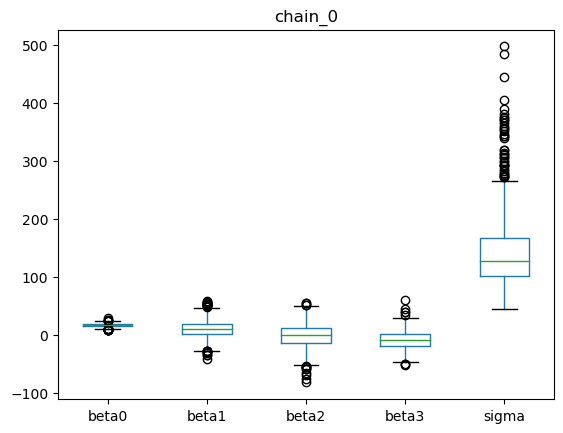

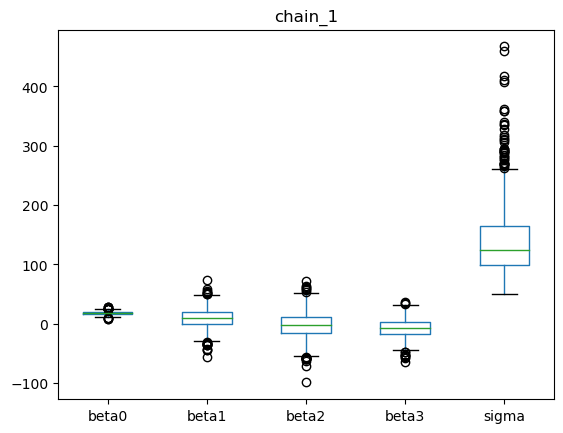

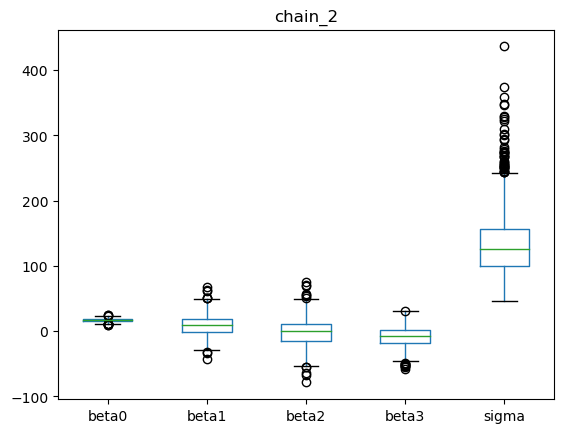

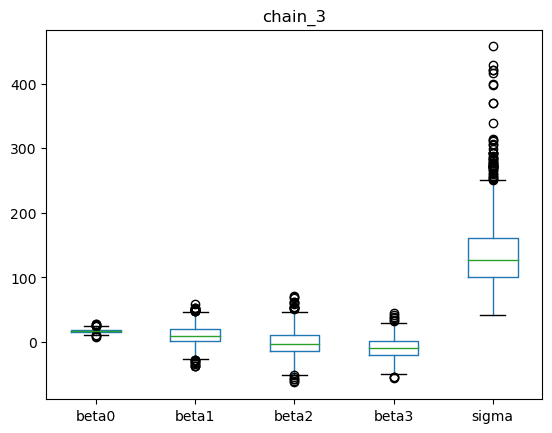

In [12]:
# Use plot_interactive=True for plotly plots offline

plot_parameters_for_n_chains(chains=['chain_0', 'chain_1', 'chain_2', 'chain_3'], parameters=parameters, plot_interactive=False)


**Joint distribution of pair of each parameter sampled values**


Pyro -- beta0 Vs. beta1


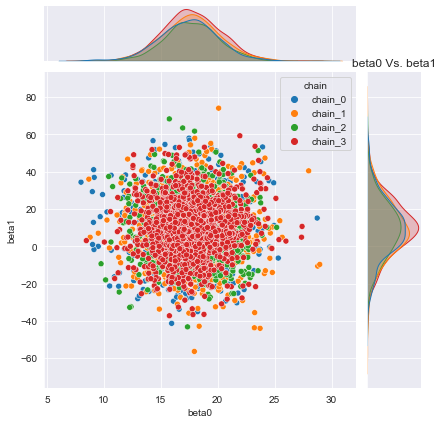


Pyro -- beta0 Vs. beta2


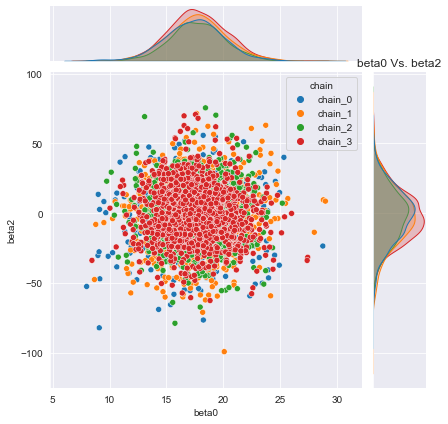


Pyro -- beta0 Vs. beta3


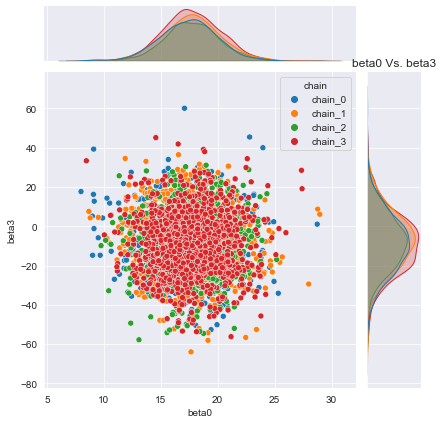


Pyro -- beta0 Vs. sigma


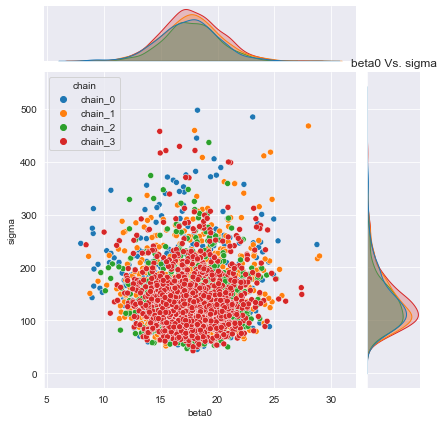


Pyro -- beta1 Vs. beta2


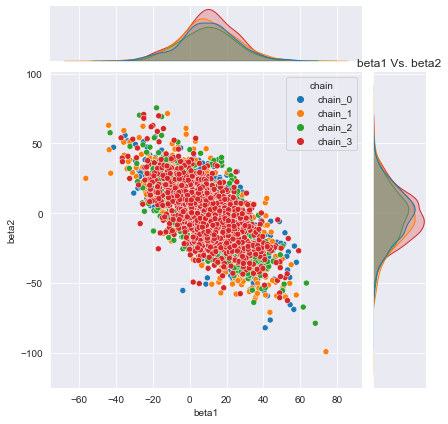


Pyro -- beta1 Vs. beta3


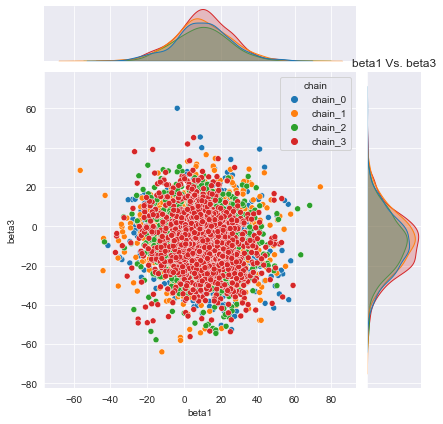


Pyro -- beta1 Vs. sigma


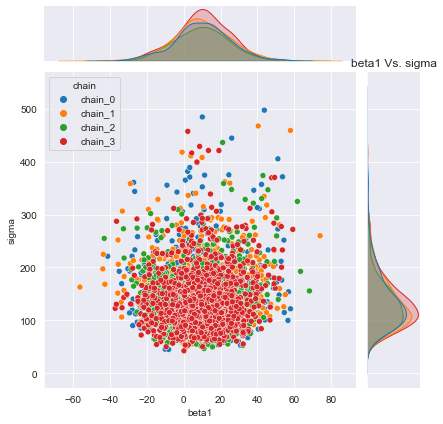


Pyro -- beta2 Vs. beta3


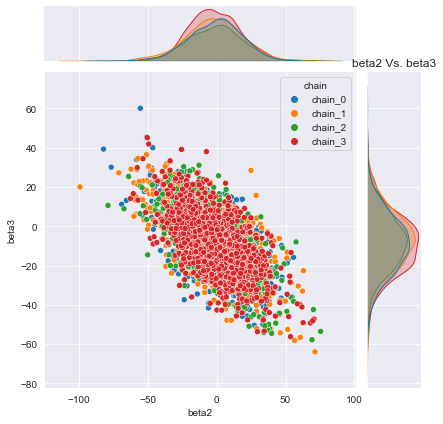


Pyro -- beta2 Vs. sigma


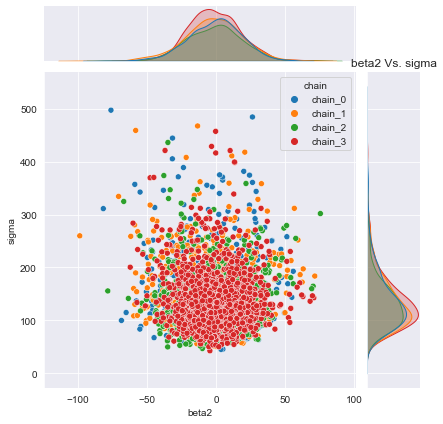


Pyro -- beta3 Vs. sigma


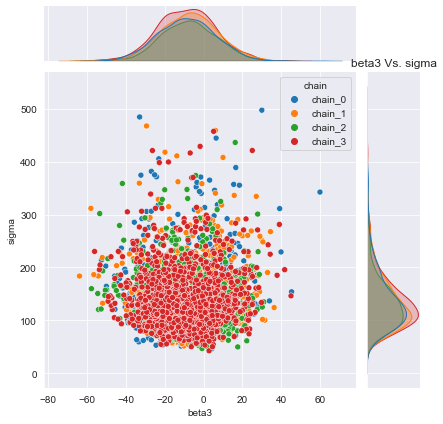

In [105]:
all_combination_params = list(itertools.combinations(parameters, 2))

for param_combo in all_combination_params:
    param1, param2= param_combo
    print("\nPyro -- %s"%(f'{param1} Vs. {param2}'))
    sns.jointplot(data=fit_df, x=param1, y=param2, hue= "chain")
    plt.title(f'{param1} Vs. {param2}')
    plt.show()
    

**Pairplot distribution of each parameter with every other parameter's sampled values**

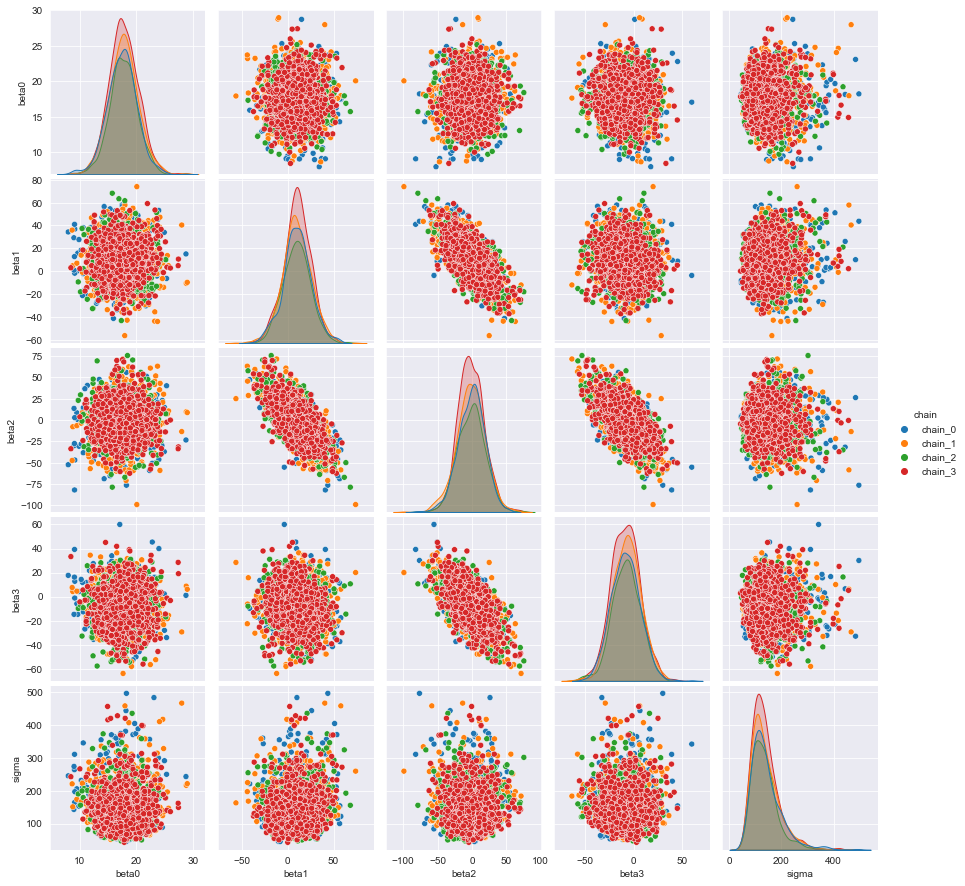

In [106]:
sns.pairplot(data=fit_df, hue= "chain");

**Hexbin plots**

In [13]:
import matplotlib.pyplot as plt
import re
import itertools

%matplotlib inline 
def hexbin_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.1
    max_x = max(list(x)+list(y)) + 0.1
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    hbin= ax.hexbin(x, y, gridsize=25, mincnt=1, cmap=plt.cm.Reds)
    cb = fig.colorbar(hbin, ax=ax)
    cb.set_label('occurence_density')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
# hexbin_plot(difficulty_df_a['difficulty_keras'], difficulty_df_a['calibrated_difficulty'], "IRT difficulty for ch-a", "calibrated difficulty for ch-a")  

In [14]:
fit_df

beta0      beta1      beta2      beta3       sigma    chain
0     18.716140  -0.093745   3.664827  -6.420473   83.274270  chain_0
1     16.050137  14.835045 -13.366175  -2.179639   87.956924  chain_0
2     17.946217  12.376676 -13.435370  -0.115782  109.809616  chain_0
3     18.919666  13.508068 -11.334033   1.136407   80.935960  chain_0
4     16.593710  17.912828  10.089385 -28.148098  144.246030  chain_0
...         ...        ...        ...        ...         ...      ...
4245  18.801388 -11.860846  14.894212  -5.222131  197.426440  chain_3
4246  18.794771  16.327187   1.692759 -21.803068  146.673390  chain_3
4247  14.808880   4.369492  10.183854 -17.592882  103.546110  chain_3
4248  21.529465  25.893454 -26.957932   3.179607   94.474625  chain_3
4249  20.978134  21.199263 -12.225398  -2.042552   92.714400  chain_3

[4250 rows x 6 columns]

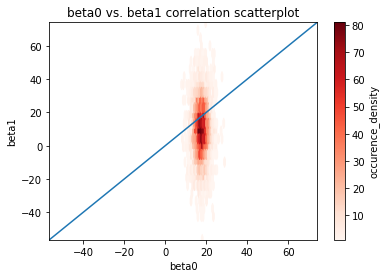

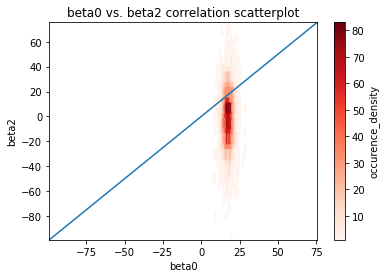

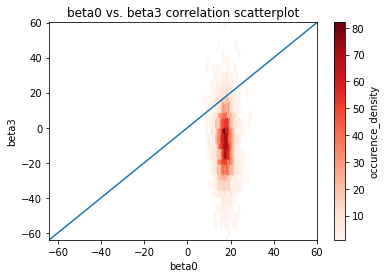

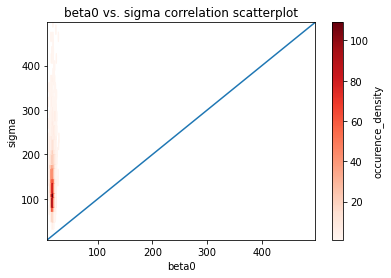

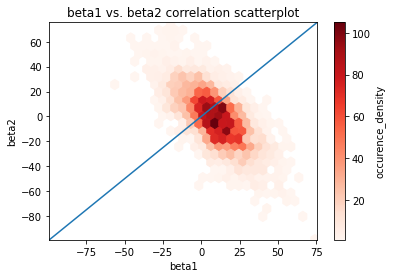

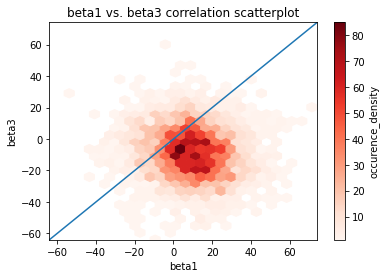

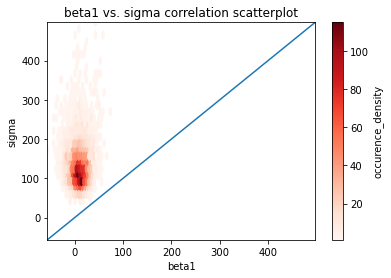

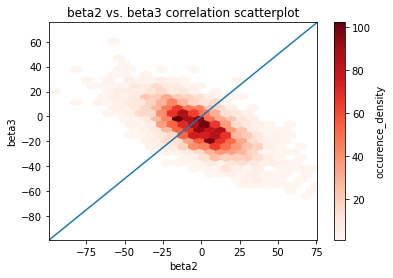

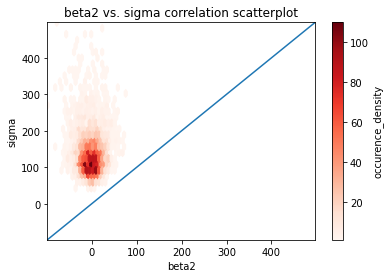

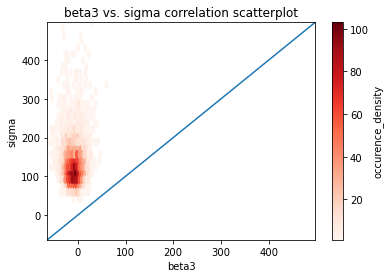

In [15]:

def plot_interaction_hexbins(fit_df, parameters=["beta0", "beta1", "beta2", "beta3", "sigma"]):
    all_combination_params = list(itertools.combinations(parameters, 2))
    for param1, param2 in all_combination_params:#Plots interaction between each of two parameters
        hexbin_plot(fit_df[param1], fit_df[param2], param1, param2)
        
plot_interaction_hexbins(fit_df, parameters=["beta0", "beta1", "beta2", "beta3", "sigma"])

**Loading Pystan model**

**Pystan model for model comparison [For now Ignore]**

In [16]:
import pystan as ps
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
# pd.options.plotting.backend = "plotly"


stacks_code = """
data {
  int<lower=0> N;
  int<lower=0> p;
  real Y[N];
  matrix[N,p] x;
} 

// to standardize the x's 
transformed data {
  matrix[N,p] z;
  row_vector[p] mean_x;
  real sd_x[p];
  for (j in 1:p) { 
    mean_x[j] <- mean(col(x,j)); 
    sd_x[j] <- sd(col(x,j)); 
    for (i in 1:N)  
      z[i,j] <- (x[i,j] - mean_x[j]) / sd_x[j]; 
  }
}

parameters {
  real beta0; 
  vector[p] beta; 
  real<lower=0> sigmasq; 
} 

transformed parameters {
  real<lower=0> sigma;
  vector[N] mu;
  sigma <- sqrt(sigmasq);
  mu <- beta0 + z * beta;
}

model {
  beta0 ~ normal(0, 316); 
  beta ~ normal(0, 316); 
  sigmasq ~ inv_gamma(.001, .001);
  Y ~ normal(mu, sigma);
} 

generated quantities {
  real b0;
  vector[p] b;
  real outlier_3;
  real outlier_4;
  real outlier_21;

  for (j in 1:p)
    b[j] <- beta[j] / sd_x[j];
  b0 <- beta0 - mean_x * b;

  outlier_3  <- step(fabs((Y[3] - mu[3]) / sigma) - 2.5);
  outlier_4  <- step(fabs((Y[4] - mu[4]) / sigma) - 2.5);
  outlier_21 <- step(fabs((Y[21] - mu[21]) / sigma) - 2.5);
}
"""

stacks_data = {"p":3, "N":21, "Y":[43, 37, 37, 28, 18, 18, 19, 20, 15, 14, 14, 13, 11, 12, 8, 
7, 8, 8, 9, 15, 15], "x":np.array([80, 80, 75, 62, 62, 62, 62, 62, 59, 58, 58, 58, 58, 
58, 50, 50, 50, 50, 50, 56, 70, 27, 27, 25, 24, 22, 23, 24, 24, 
23, 18, 18, 17, 18, 19, 18, 18, 19, 19, 20, 20, 20, 89, 88, 90, 
87, 87, 87, 93, 93, 87, 80, 89, 88, 82, 93, 89, 86, 72, 79, 80, 
82, 91]).reshape((21,3))}

In [18]:
posterior = ps.StanModel(model_code=stacks_code)#, data=schools_data, random_seed=1)
fit = posterior.sampling(data=stacks_data, iter=1000, chains=4, seed=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3e0eded9705315cb92017c5ad079b544 NOW.


In [29]:
print(fit)

Inference for Stan model: anon_model_3e0eded9705315cb92017c5ad079b544.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0       17.52    0.06   2.51  12.46  15.95  17.54  19.15  22.31   1734    1.0
beta[1]     10.63    0.45  14.78 -17.47   0.52  10.39  20.13  40.77   1096    1.0
beta[2]     -2.01    0.64  19.51 -41.29 -14.55   -2.7  11.06  37.73    935    1.0
beta[3]     -8.49    0.47  14.65 -37.19 -17.68  -9.16   1.02  20.01    988    1.0
sigmasq    134.15    1.77  52.33  67.66  97.02 122.73 156.08 259.31    878    1.0
sigma       11.39    0.07   2.09   8.23   9.85  11.08  12.49   16.1    935    1.0
mu[1]       19.62    0.12   4.42   10.6  16.76  19.57  22.41  28.19   1414    1.0
mu[2]       17.86    0.06    2.6  12.52  16.22  17.82  19.54  22.93   1642    1.0
mu[3]       18.75    0.08   3.12  12.24  16.79  18.75  20.77  24.79   1483 

In [61]:
params_pystan= fit.extract()
params_pystan

OrderedDict([('beta0',
              array([18.4674982 , 20.9569108 , 19.40835325, ..., 18.08549742,
                     16.48787943, 16.51161674])),
             ('beta', array([[-11.81028733,  14.39751803,  -1.95369233],
                     [  8.03125587,  -5.31946233,  -5.170025  ],
                     [ 46.16845001, -34.93013092, -12.72308535],
                     ...,
                     [ -6.48131152,  21.60708789, -12.53271005],
                     [ 22.47763628, -23.67534644,   4.10612246],
                     [ -4.60801019,  21.69814434, -15.51879342]])),
             ('sigmasq',
              array([123.61848214, 106.59748736, 166.85860894, ...,  72.93862461,
                     151.24362851, 142.94254906])),
             ('sigma',
              array([11.11838487, 10.32460592, 12.91737624, ...,  8.54041127,
                     12.29811484, 11.95585836])),
             ('mu',
              array([[18.93103672, 18.3011084 , 18.50584078, ..., 23.7549901 ,
             

In [22]:
fit_df_pystan= fit.to_dataframe()
fit_df_pystan.to_csv("data/stack_regression_hmc_samples[pystan].csv", index=False)
fit_df_pystan

chain  draw  warmup      beta0    beta[1]    beta[2]    beta[3]  \
0         0     0       0  18.928377   3.155693  -2.190858  -4.371486   
1         0     1       0  18.568419   8.092747   8.623133 -18.964355   
2         0     2       0  16.428101  24.290694 -33.413709   8.423697   
3         0     3       0  17.070876  -0.312046  -7.598830   6.574173   
4         0     4       0  16.028532  -3.098011  -5.068651   6.492513   
...     ...   ...     ...        ...        ...        ...        ...   
1995      3   495       0  16.952399   8.258991  25.048287 -37.674257   
1996      3   496       0  18.441020   1.885997  24.017403 -27.422503   
1997      3   497       0  19.290214  -8.942330  26.727451 -18.025183   
1998      3   498       0  19.100227  -9.693598  27.820101 -17.347120   
1999      3   499       0  18.463724   5.351314  19.549980 -25.523326   

         sigmasq      sigma      mu[1]  ...  outlier_3  outlier_4  outlier_21  \
0     121.684728  11.031080  16.989106  ...        0.0        0.0         0.0   
1      71.151562   8.435139  20.537808  ...        0.0        0.0         0.0   
2     151.920084  12.325587  15.155982  ...        0.0        0.0         0.0   
3     120.108512  10.959403  14.692378  ...        0.0        0.0         0.0   
4     105.361024  10.264552  13.276498  ...        0.0        0.0         0.0   
...          ...        ...        ...  ...        ...        ...         ...   
1995  165.547837  12.866539  20.658131  ...        0.0        0.0         0.0   
1996  121.167232  11.007599  22.387479  ...        0.0        0.0         0.0   
1997   67.672967   8.226358  22.146370  ...        0.0        0.0         0.0   
1998   66.384168   8.147648  22.662469  ...        0.0        0.0         0.0   
1999   91.857778   9.584246  22.939993  ...        0.0        0.0         0.0   

           lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -60.020297       0.770160    0.072835            4            27   
1    -60.343891       0.981741    0.072835            5            31   
2    -60.658132       0.985818    0.072835            6            63   
3    -59.660293       0.949237    0.072835            6            63   
4    -60.037600       0.987064    0.072835            5            63   
...         ...            ...         ...          ...           ...   
1995 -62.338117       0.934744    0.095552            5            31   
1996 -60.080147       0.970496    0.095552            5            31   
1997 -61.809377       0.995654    0.095552            5            31   
1998 -62.104940       0.885800    0.095552            5            31   
1999 -59.723045       0.486334    0.095552            5            31   

      divergent__   energy__  
0               0  62.718299  
1               0  61.407529  
2               0  62.314234  
3               0  62.096187  
4               0  60.431712  
...           ...        ...  
1995            0  62.886475  
1996            0  62.811395  
1997            0  63.364392  
1998            0  62.617802  
1999            0  65.551342  

[2000 rows x 44 columns]

In [ ]:
# Use following once the results from Pystan sampling operation are saved offline

# fit_df_pystan= pd.read_csv("data/stack_regression_hmc_samples[pystan].csv")
# fit_df_pystan

**Obtain 5 point Summary statics (mean, Q1-Q4, Std, ) as tabular data per chain.**


In [16]:
summary_stats_df_pystan= pd.DataFrame()

for param in ["beta0", "beta[1]", "beta[2]", "beta[3]"]:
    for name, groupdf in fit_df_pystan.groupby("chain"):
        groupdi = dict(groupdf[param].describe())
        
        values = dict(map(lambda key:(key, [groupdi.get(key)]), ['mean', 'std', '25%', '50%', '75%']))
        values.update({"parameter": param, "chain":name})
        summary_stats_df= pd.DataFrame(values)
        summary_stats_df_pystan= pd.concat([summary_stats_df_pystan, summary_stats_df], axis=0)
summary_stats_df_pystan.set_index(["parameter", "chain"], inplace=True)
summary_stats_df_pystan

mean        std        25%        50%        75%
parameter chain                                                       
beta0     0      17.571099   2.605869  15.816209  17.543887  19.329250
          1      17.575962   2.575488  16.022127  17.697151  19.206536
          2      17.438131   2.585339  15.834982  17.447945  19.201057
          3      17.488556   2.265300  16.055608  17.486719  18.901170
beta[1]   0      11.037135  15.267408   0.170137  10.841768  21.652315
          1      10.890145  14.611592   0.691986  11.551165  20.636765
          2       9.469683  14.631706   0.285248   8.651789  17.795402
          3      11.104806  14.595227   0.955593  10.605308  20.736721
beta[2]   0      -3.471325  19.784070 -15.716704  -3.257380  10.650848
          1      -2.064484  20.066303 -15.201950  -2.438730  10.997859
          2      -1.024488  19.811979 -12.139112  -2.267048  11.431169
          3      -1.479858  18.279741 -13.180875  -2.478856  11.111396
beta[3]   0      -7.408327  15.426092 -17.112597  -7.785987   2.352674
          1      -8.596175  15.746260 -18.154305  -9.713069   1.001033
          2      -8.375658  13.977804 -17.215732  -8.970723   1.377498
          3      -9.579874  13.260106 -17.613307  -9.552650  -0.770513

In [17]:
fit_df_pystan.head(5)

chain  draw  warmup  ...  n_leapfrog__  divergent__   energy__
0      0     0       0  ...            27            0  62.718299
1      0     1       0  ...            31            0  61.407529
2      0     2       0  ...            63            0  62.314234
3      0     3       0  ...            63            0  62.096187
4      0     4       0  ...            63            0  60.431712

[5 rows x 44 columns]

**Following Plots m parameters side by side for n chains**

In [23]:
parameters_pystan= ["beta0", "beta[1]", "beta[2]", "beta[3]"]# All parameters for given model
chains_pystan= fit_df_pystan["chain"].unique()# Number of chains sampled for given model


func_all_params_per_chain_pystan = lambda param, chain: (param, fit_df_pystan[fit_df_pystan["chain"]==chain][param].tolist())
func_all_chains_per_param_pystan = lambda chain, param: (f'Chain_{chain}', fit_df_pystan[param][fit_df_pystan["chain"]==chain].tolist())

di_all_params_per_chain_pystan = dict(map(lambda param: func_all_params_per_chain_pystan(param, 0), parameters_pystan))
di_all_chains_per_param_pystan = dict(map(lambda chain: func_all_chains_per_param_pystan(chain, "beta0"), chains_pystan))

In [24]:

def plot_parameters_for_n_chains_pystan(chains=[0], parameters=["beta0", "beta[1]", "beta[2]", "beta[3]"], plotting_cap=[4, 4], plot_interactive=False):
    try:
        chain_cap, param_cap = plotting_cap#
        assert len(chains)<=chain_cap, "Cannot plot Number of chains greater than %s!"%chain_cap
        assert len(parameters)<=param_cap, "Cannot plot Number of parameters greater than %s!"%param_cap
        
        for chain in chains:
            di_all_params_per_chain = dict(map(lambda param: func_all_params_per_chain_pystan(param, chain), parameters))
            df_all_params_per_chain = pd.DataFrame(di_all_params_per_chain)
            if df_all_params_per_chain.empty:
#                 raise Exception("Invalid chain number in context of model!")
                print("Note: Chain number [%s] is Invalid in context of this model!"%chain)
                continue

            if plot_interactive:
              df_all_params_per_chain= df_all_params_per_chain.unstack().reset_index(level=0)
              df_all_params_per_chain.rename(columns={"level_0":"parameters", 0:"values"}, inplace=True)
              fig = px.box(df_all_params_per_chain, x="parameters", y="values")
              fig.update_layout(height=600, width=900, title_text=f'chain_{chain}')
              fig.show()
            else:
              df_all_params_per_chain.plot.box()
              plt.title(f'chain_{chain}')

    except Exception as error:
        if type(error) is AssertionError:
            print("Note: %s"%error)
            chains = np.random.choice(chains, chain_cap, replace=False)
            parameters=np.random.choice(parameters, param_cap, replace=False)
            plot_parameters_for_n_chains(chains, parameters)
        else: print("Error: %s"%error)


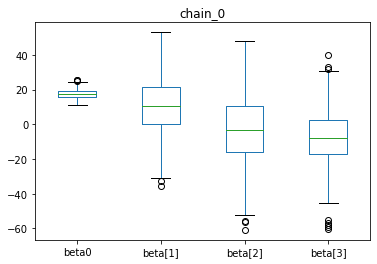

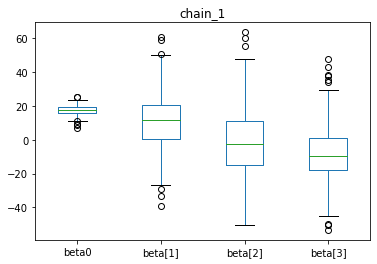

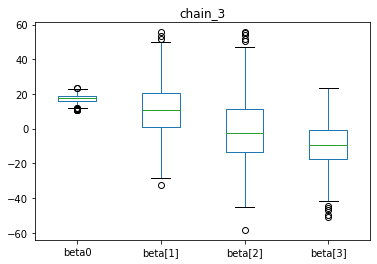

In [25]:
# Use plot_interactive=True for plotly plots offline

plot_parameters_for_n_chains_pystan(chains=[0, 1, 3], parameters=["beta0", "beta[1]", "beta[2]", "beta[3]"], plot_interactive=False)


**Following Plots n chains side by side for m parameters**

In [26]:
def plot_chains_for_n_parameters_pystan(parameters=["beta0", "beta[1]", "beta[2]", "beta[3]"], chains=[0,1,2,3,4], plotting_cap=[4, 4], plot_interactive=False):
    screen_invalid_chains = lambda chain_val: True if not chain_val[1] else False# Filters Invalid chain results
    screen_valid_chain_results = lambda chain_val: True if chain_val[1] else False# Filters valid chain results
    try:
        chain_cap, param_cap = plotting_cap#
        assert len(chains)<=chain_cap, "Cannot plot Number of chains greater than %s!"%chain_cap
        assert len(parameters)<=param_cap, "Cannot plot Number of parameters greater than %s!"%param_cap
        
        for param in parameters:
#             di_all_params_per_chain = dict(map(lambda param: func_all_params_per_chain(param, chain), parameters))
            
            di_all_chains_per_param = dict(map(lambda chain: func_all_chains_per_param_pystan(chain, param), chains))

            invalid_chains = dict(filter(screen_invalid_chains, list(di_all_chains_per_param.items())))
            
            valid_chain_results = dict(filter(screen_valid_chain_results, list(di_all_chains_per_param.items())))
            
            df_all_chains_per_param = pd.DataFrame(valid_chain_results)

            
            if plot_interactive:
              df_all_chains_per_param= df_all_chains_per_param.unstack().reset_index(level=0)
              df_all_chains_per_param.rename(columns={"level_0":"chains", 0:"values"}, inplace=True)
              fig = px.box(df_all_chains_per_param, x="chains", y="values")
              fig.update_layout(height=600, width=900, title_text=f'parameter: {param}')
              fig.show()
            else:
              df_all_chains_per_param.plot.box()
              plt.title(f'parameter: {param}')
            
            # fig= df_all_chains_per_param.plot.box()# Uncomment if pandas backend is set to "plotly"
            # fig.update_layout(height=600, width=900, title_text=f'parameter: {param}')
            # fig.show()
            if invalid_chains:
                print("Note: Chain numbers %s are Invalid in context of this model!"%list(invalid_chains.keys()))
    except Exception as error:
        if type(error) is AssertionError:
            print("Note: %s"%error)
            chains = np.random.choice(chains, chain_cap, replace=False)
            parameters=np.random.choice(parameters, param_cap, replace=False)
            plot_chains_for_n_parameters(parameters, chains)
        else: print("Error: %s"%error)

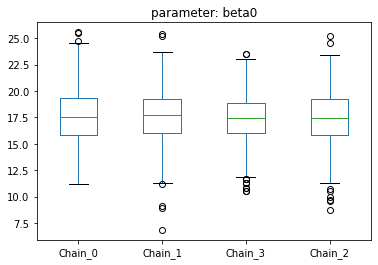

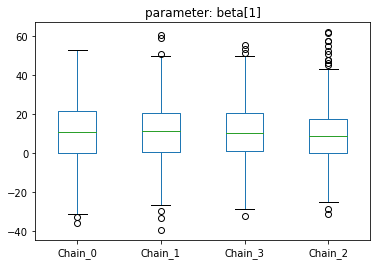

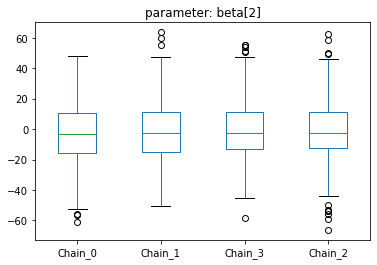

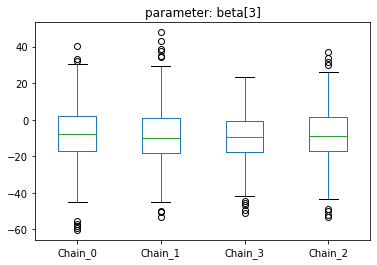

In [27]:
# Use plot_interactive=True for plotly plots offline


plot_chains_for_n_parameters_pystan(parameters=["beta0", "beta[1]", "beta[2]", "beta[3]"], chains=[0, 1, 3, 2], plot_interactive=False)


In [28]:
# Uncomment following to view plotly plots offline

# di_all_chains_per_param_pystan = dict(map(lambda chain: func_all_chains_per_param_pystan(chain, param), chains_pystan))

# df_all_chains_per_param_pystan = pd.DataFrame(di_all_chains_per_param_pystan)
# df_all_chains_per_param_sqeezed_pystan = df_all_chains_per_param_pystan.melt(value_name='posterior').rename(columns={"variable":"chains"})

# fig_2 = px.box(df_all_chains_per_param_sqeezed_pystan, x="chains", y="posterior", points="all")
# fig_2.show()

In [95]:
fit_df_pystan_trunc = fit_df_pystan[['chain', 'beta0', 'beta[1]', 'beta[2]', 'beta[3]', 'sigma']].copy()
fit_df_pystan_trunc["chain"]=fit_df_pystan_trunc["chain"].apply(lambda x: f'chain_{x}')
fit_df_pystan_trunc.head(3)

chain      beta0    beta[1]    beta[2]    beta[3]      sigma
0  chain_0  18.928377   3.155693  -2.190858  -4.371486  11.031080
1  chain_0  18.568419   8.092747   8.623133 -18.964355   8.435139
2  chain_0  16.428101  24.290694 -33.413709   8.423697  12.325587

**Joint distribution of pair of each parameter sampled values**


Pystan -- beta0 Vs. beta[1]


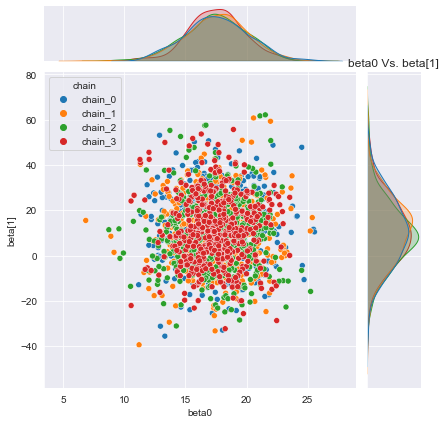


Pystan -- beta0 Vs. beta[2]


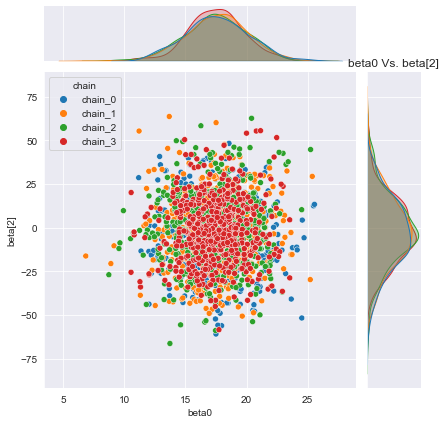


Pystan -- beta0 Vs. beta[3]


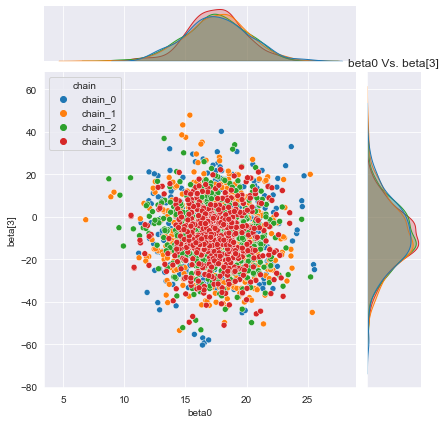


Pystan -- beta0 Vs. sigma


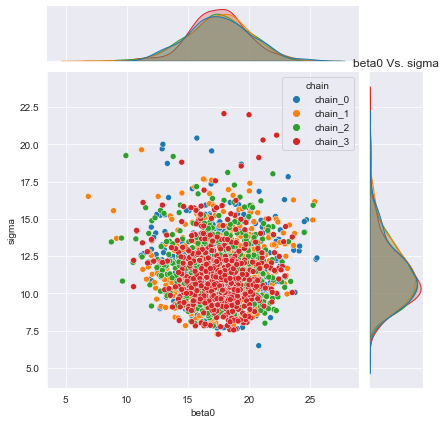


Pystan -- beta[1] Vs. beta[2]


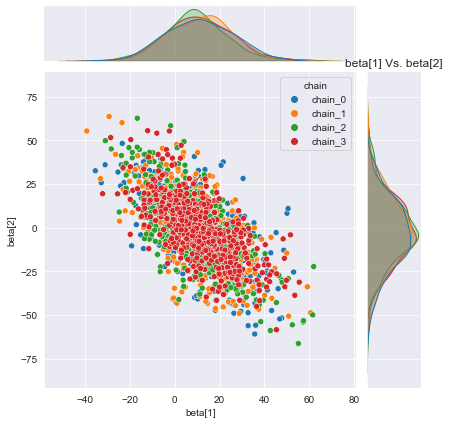


Pystan -- beta[1] Vs. beta[3]


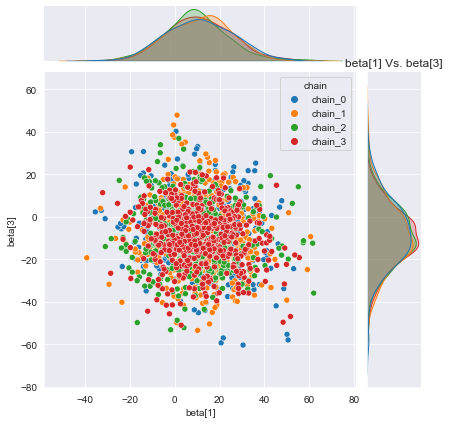


Pystan -- beta[1] Vs. sigma


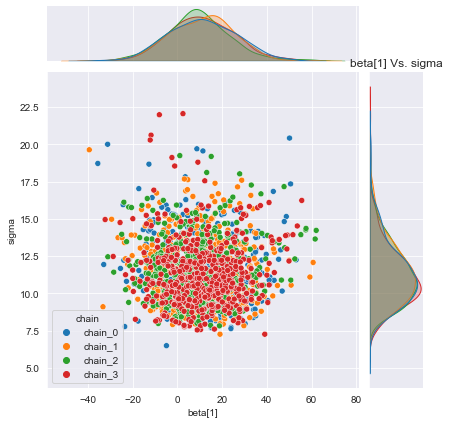


Pystan -- beta[2] Vs. beta[3]


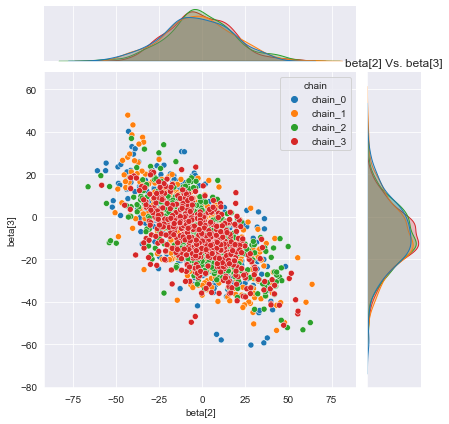


Pystan -- beta[2] Vs. sigma


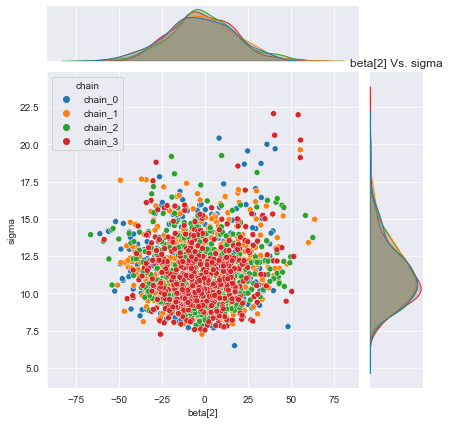


Pystan -- beta[3] Vs. sigma


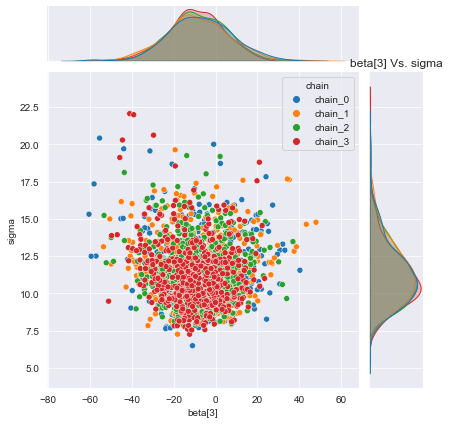

In [107]:
all_combination_params = list(itertools.combinations(['beta0', 'beta[1]', 'beta[2]', 'beta[3]', 'sigma'], 2))

for param_combo in all_combination_params:
    param1, param2= param_combo
    print("\nPystan -- %s"%(f'{param1} Vs. {param2}'))
    sns.jointplot(data=fit_df_pystan_trunc, x=param1, y=param2, hue= "chain")
    plt.title(f'{param1} Vs. {param2}')
    plt.show()

**Pairplot distribution of each parameter with every other parameter's sampled values**

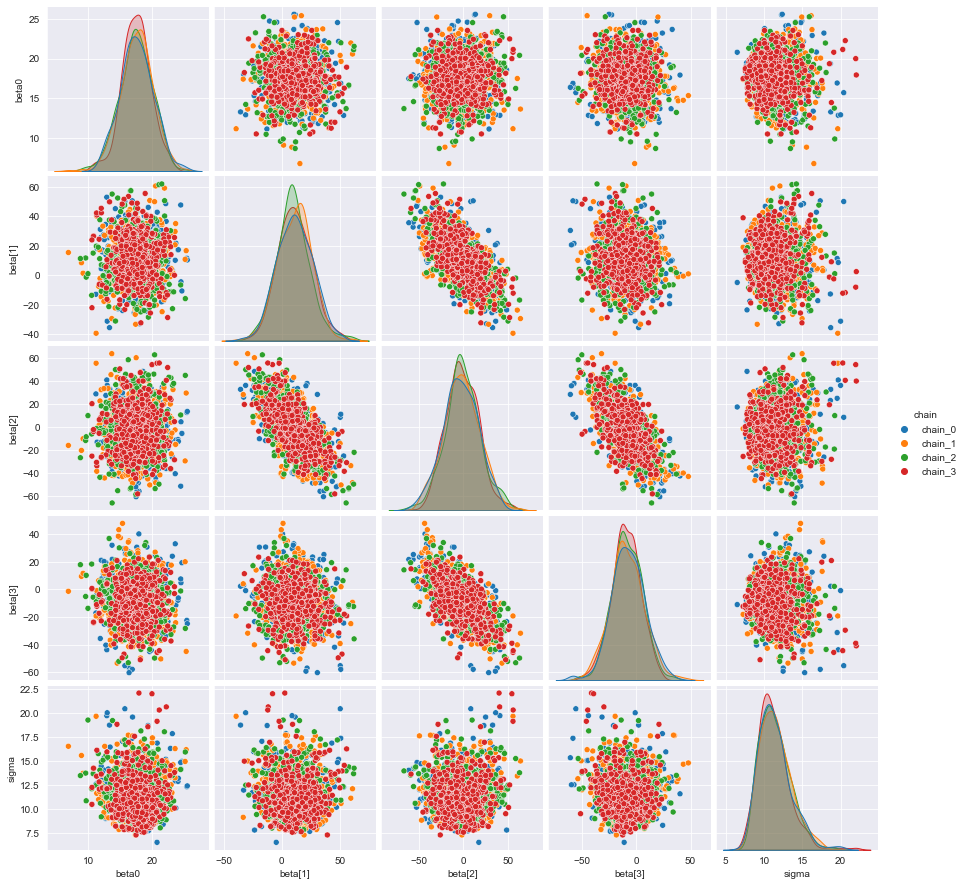

In [108]:
sns.pairplot(data=fit_df_pystan_trunc, hue= "chain");

**Plot hexbin scatterplot for each parameter with respect to other parameters**

In [60]:
params_pystan

OrderedDict([('beta0',
              array([18.4674982 , 20.9569108 , 19.40835325, ..., 18.08549742,
                     16.48787943, 16.51161674])),
             ('beta', array([[-11.81028733,  14.39751803,  -1.95369233],
                     [  8.03125587,  -5.31946233,  -5.170025  ],
                     [ 46.16845001, -34.93013092, -12.72308535],
                     ...,
                     [ -6.48131152,  21.60708789, -12.53271005],
                     [ 22.47763628, -23.67534644,   4.10612246],
                     [ -4.60801019,  21.69814434, -15.51879342]])),
             ('sigmasq',
              array([123.61848214, 106.59748736, 166.85860894, ...,  72.93862461,
                     151.24362851, 142.94254906])),
             ('sigma',
              array([11.11838487, 10.32460592, 12.91737624, ...,  8.54041127,
                     12.29811484, 11.95585836])),
             ('mu',
              array([[18.93103672, 18.3011084 , 18.50584078, ..., 23.7549901 ,
             

In [63]:

def plot_interaction_hexbins_pystan(params, parameters=['beta0', 'beta[1]', 'beta[2]', 'beta[3]']):
    all_param_keys_unison = "|".join((dict(params).keys()))# example - "beta0|beta|sigmasq|"
    filter_param_keys = lambda param: (param, re.findall(all_param_keys_unison, param)[0])

    parameters_to_select_param_map = dict(map(filter_param_keys, parameters))# outputs - {'beta0': 'beta0', 'beta[1]': 'beta', 'beta[2]': 'beta', 'beta[3]': 'beta'}

    select_param_keys= set(parameters_to_select_param_map.values())

    sliced_param_di = dict(map(lambda param: (param, dict(params).get(param)), select_param_keys))
    all_combination_params = list(itertools.combinations(parameters, 2))

    # parameters
    final_param_di= {}
    for param in sorted(parameters):
        arr= sliced_param_di[parameters_to_select_param_map.get(param)]
        if arr.ndim>1:# For params other than intercept/ bias/ beta0
            final_param_di[param]= arr[:, 0]
            arr= np.delete(arr, 0, 1)

        else: final_param_di[param]=arr
        sliced_param_di[parameters_to_select_param_map.get(param)]= arr


    for param1, param2 in all_combination_params:#Plots interaction between each of two parameters
        hexbin_plot(final_param_di[param1], final_param_di[param2], param1, param2)

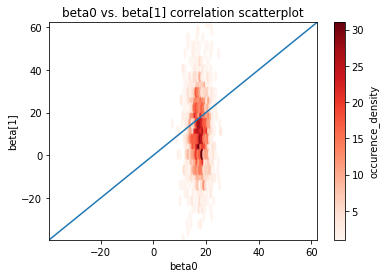

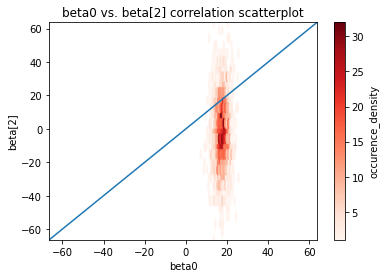

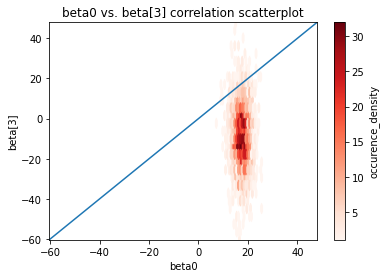

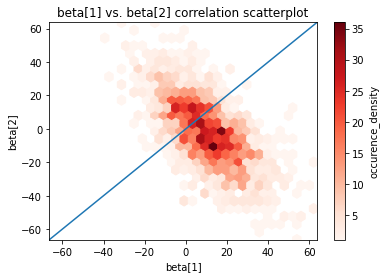

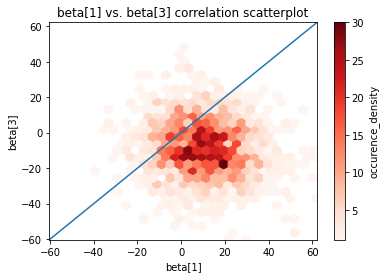

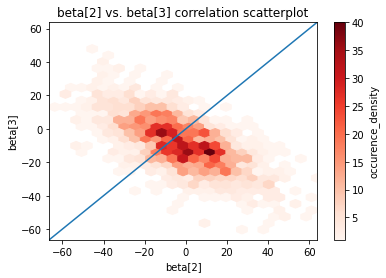

In [64]:
plot_interaction_hexbins_pystan(params_pystan, parameters=['beta0', 'beta[1]', 'beta[2]', 'beta[3]'])
#plot_interaction_hexbins(params, parameters=['beta[1]', 'beta[2]', 'beta[3]'])

**Plotting Intermixing of Chains from Pyro & Pystan**

In [31]:
# chains_pyro_pystan -- list of all chains from pyro & pystan 
chains_pyro_pystan = list(fit_df["chain"].unique())+ list(fit_df_pystan["chain"].unique())


# parameter_pyro_pystan_map -- map of each parameter between pyro & pystan
parameter_pyro_pystan_map = {'beta0': 'beta0', 'beta1': 'beta[1]', 'beta2': 'beta[2]','beta3': 'beta[3]', 'sigma': 'sigma'}

chains_pyro_pystan

['chain_0', 'chain_1', 'chain_2', 'chain_3', 0, 1, 2, 3]

In [41]:
fit_df.head(2)

beta0      beta1      beta2     beta3      sigma    chain
0  18.716140  -0.093745   3.664827 -6.420473  83.274270  chain_0
1  16.050137  14.835045 -13.366175 -2.179639  87.956924  chain_0

In [39]:
fit_df_pystan.head(2)

chain  draw  warmup      beta0   beta[1]   beta[2]    beta[3]     sigmasq  \
0      0     0       0  18.928377  3.155693 -2.190858  -4.371486  121.684728   
1      0     1       0  18.568419  8.092747  8.623133 -18.964355   71.151562   

       sigma      mu[1]  ...  outlier_3  outlier_4  outlier_21       lp__  \
0  11.031080  16.989106  ...        0.0        0.0         0.0 -60.020297   
1   8.435139  20.537808  ...        0.0        0.0         0.0 -60.343891   

   accept_stat__  stepsize__  treedepth__  n_leapfrog__  divergent__  \
0       0.770160    0.072835            4            27            0   
1       0.981741    0.072835            5            31            0   

    energy__  
0  62.718299  
1  61.407529  

[2 rows x 44 columns]


For pyro_parameter: beta0 & pystan_parameter: beta0


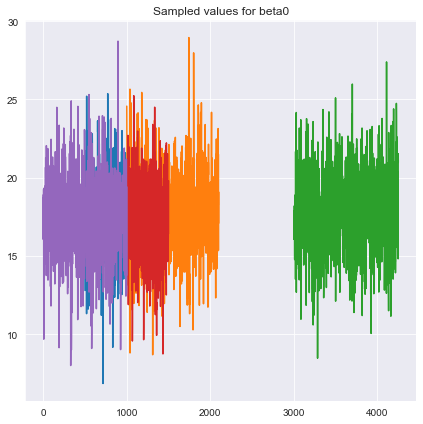


For pyro_parameter: beta1 & pystan_parameter: beta[1]


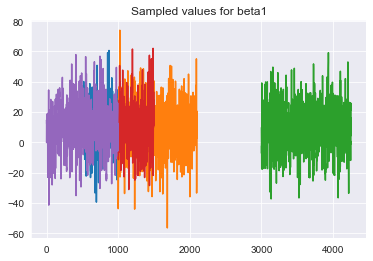


For pyro_parameter: beta2 & pystan_parameter: beta[2]


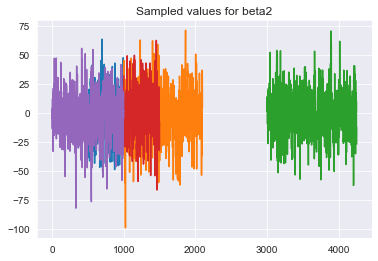


For pyro_parameter: beta3 & pystan_parameter: beta[3]


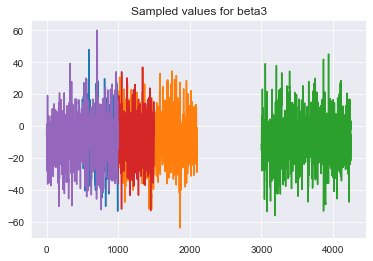


For pyro_parameter: sigma & pystan_parameter: sigma


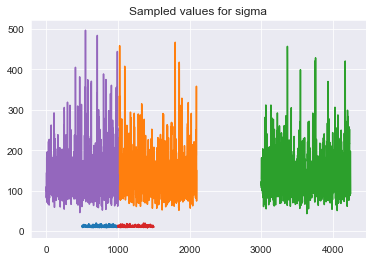

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

pyro_parameters_to_plot= ['beta0', 'beta1', 'beta2', 'beta3', 'sigma']# list(parameter_pyro_pystan_map.keys())
chains_to_plot = list(np.random.choice(chains_pyro_pystan, 5))
all_params_chains_df= pd.DataFrame()

sns.set_style("darkgrid")
fig= plt.figure(figsize=(7,7))
for param in pyro_parameters_to_plot:
    param_pystan= parameter_pyro_pystan_map.get(param)
    all_chains_df= pd.DataFrame()
    print("\nFor pyro_parameter: %s & pystan_parameter: %s"%(param, param_pystan))
    for chain in chains_to_plot:
        chain = int(chain) if chain.isnumeric() else chain
    #     if chain in list(fit_df_pystan["chain"].apply(str).unique()):
        if chain in list(fit_df_pystan["chain"].unique()):# Plots pystan chain
            all_chains_df_ = pd.DataFrame({param:fit_df_pystan[fit_df_pystan["chain"]==chain][param_pystan].tolist()})

            plt.plot(fit_df_pystan[fit_df_pystan["chain"]==chain][param_pystan])
#             plt.legend(f'pystan chain_{chain}', ncol=2, loc='upper left');
        else:
            all_chains_df_ =pd.DataFrame({param:fit_df[fit_df["chain"]==chain][param].tolist()})

            plt.plot(fit_df[fit_df["chain"]==chain][param])
#             plt.legend(f'pyro {chain}', ncol=2, loc='upper left');
        all_chains_df_["chain"] = chain
        all_chains_df =pd.concat([all_chains_df, all_chains_df_], axis=0)
#     all_chains_df["parameter"] = param
    all_params_chains_df= pd.concat([all_params_chains_df, all_chains_df], axis=1)

    plt.title("Sampled values for %s"%(param))
    plt.show()

In [220]:
all_params_chains_df.head(2)

beta0 chain      beta1 chain      beta2 chain      beta3 chain  \
0  12.788365     1  15.809973     1  -1.126719     1 -15.963440     1   
1  21.499847     1  13.663175     1 -28.954790     1  16.717279     1   

       sigma chain  
0   9.129729     1  
1  11.248045     1

In [221]:
all_params_chains_df_ = all_params_chains_df.copy()

all_params_chains_df_ = all_params_chains_df_.loc[:,~all_params_chains_df_.columns.duplicated()]
all_params_chains_df_.head(3)

beta0 chain      beta1      beta2      beta3      sigma
0  12.788365     1  15.809973  -1.126719 -15.963440   9.129729
1  21.499847     1  13.663175 -28.954790  16.717279  11.248045
2  19.151705     1  13.546544 -27.493113  15.931952  12.518611

**Pairplot distribution of each parameter with every other parameter's sampled values**
* Note: resulting density plots are from chains from both pyro & pystan sampling

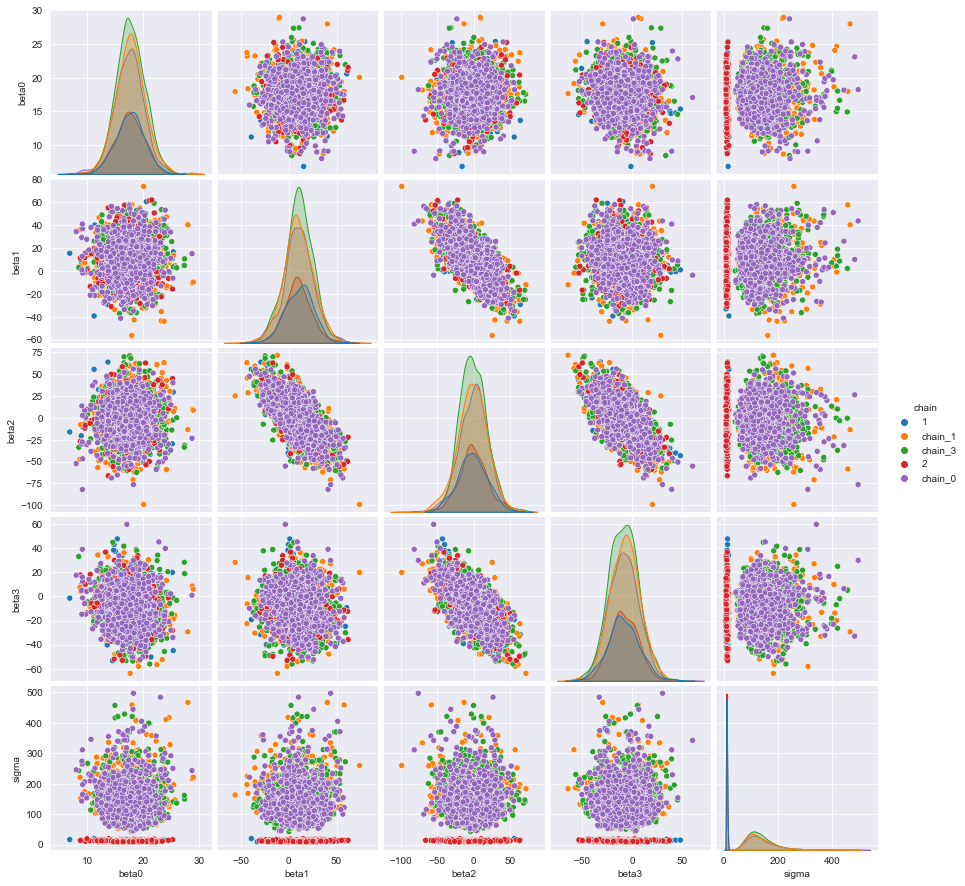

In [222]:
sns.pairplot(data=all_params_chains_df_, hue="chain");

_______________